In [20]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility == 난수 생성을 위한 초기값(initial value)
#manualSeed = 999

manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  5006


## Inputs

Let’s define some inputs for the run:

-  ``dataroot`` - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section.
-  ``workers`` - the number of worker threads for loading the data with
   the ``DataLoader``.
-  ``batch_size`` - the batch size used in training. The DCGAN paper
   uses a batch size of 128.
-  ``image_size`` - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   [here](https://github.com/pytorch/examples/issues/70)_ for more
   details.
-  ``nc`` - number of color channels in the input images. For color
   images this is 3.
-  ``nz`` - length of latent vector.
-  ``ngf`` - relates to the depth of feature maps carried through the
   generator.
-  ``ndf`` - sets the depth of feature maps propagated through the
   discriminator.
-  ``num_epochs`` - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer.
-  ``lr`` - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002.
-  ``beta1`` - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5.
-  ``ngpu`` - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs.




In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataroot = '/content/drive/MyDrive/GAN0711/faces/img_align_celeba'

In [4]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
import zipfile
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [6]:
# CustomDataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None, max_samples=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

        # 최대 샘플 갯수를 지정한다면, 리스트를 해당 갯수만큼 제한합니다.
        if max_samples:
            self.image_files = self.image_files[:max_samples]

        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image


In [22]:
# 이미지 변환 설정
transform = transforms.Compose([
                    transforms.Resize((64, 64)),  # 이미지 크기를 조정합니다.
                    transforms.ToTensor(),  # 이미지를 텐서로 변환합니다.
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])

# CustomDataset을 사용하여 데이터셋을 구성 (최대 5000장의 이미지만 불러옵니다)
train_ds = CustomDataset(folder_path='/content/drive/MyDrive/GAN0711/faces/img_align_celeba/', transform=transform, max_samples= 7500)


# 바꿔준 이미지들을 DataLoader로 호출
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True, num_workers = 2)

In [ ]:
from PIL import Image

# image_path = "/content/drive/MyDrive/GAN0711/faces/202599.jpg"
# # 이미지 열기
# img = Image.open(image_path)

# # 이미지 차원 확인
# width, height = img.size
# print(f"The dimensions of the image are {width}x{height}")

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

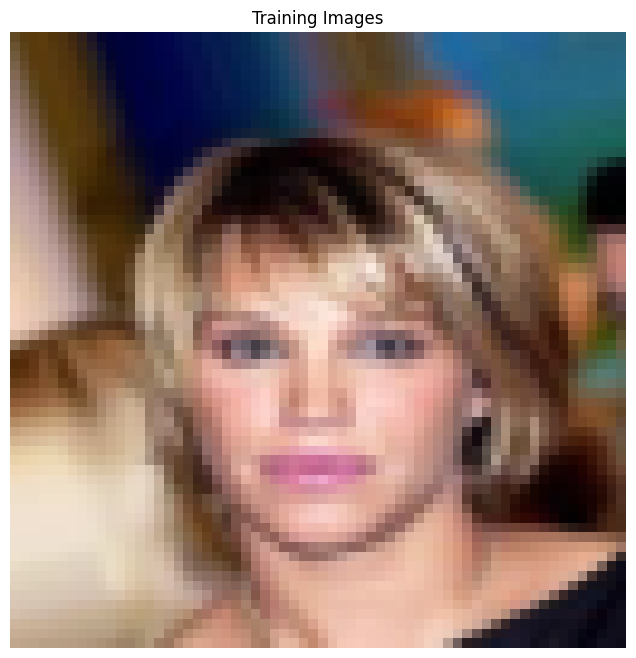

In [ ]:
# Plot some training images
real_batch = next(iter(train_dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),

        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [18]:
# Initialize the ``MSELoss`` function
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

In [35]:
# Training Loop
# Number of training epochs
num_epochs = 80
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dl):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        real_cpu = real_cpu.unsqueeze(0)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        #output = netD(real_cpu).view(-1)
        output = netD(real_cpu).view(-1) # 채널 차원 추가

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dl),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/80][0/59]	Loss_D: 0.1890	Loss_G: 0.9553	D(x): 0.5742	D(G(z)): 0.0876 / 0.0226
[0/80][10/59]	Loss_D: 0.1626	Loss_G: 0.7734	D(x): 0.7180	D(G(z)): 0.2882 / 0.1206
[0/80][20/59]	Loss_D: 1.3634	Loss_G: 1.1568	D(x): 0.1457	D(G(z)): -0.7960 / -0.0756
[0/80][30/59]	Loss_D: 0.9764	Loss_G: 0.8092	D(x): 1.4703	D(G(z)): 0.8690 / 0.1004
[0/80][40/59]	Loss_D: 0.4327	Loss_G: 0.7734	D(x): 0.3572	D(G(z)): 0.1397 / 0.1206
[0/80][50/59]	Loss_D: 0.0096	Loss_G: 1.0365	D(x): 1.0976	D(G(z)): -0.0084 / -0.0181
[1/80][0/59]	Loss_D: 0.1356	Loss_G: 0.5543	D(x): 1.0156	D(G(z)): 0.3679 / 0.2555
[1/80][10/59]	Loss_D: 0.2252	Loss_G: 1.0296	D(x): 0.7192	D(G(z)): 0.3826 / -0.0147
[1/80][20/59]	Loss_D: 0.1526	Loss_G: 0.7029	D(x): 0.6208	D(G(z)): 0.0937 / 0.1616
[1/80][30/59]	Loss_D: 0.0013	Loss_G: 1.0316	D(x): 0.9666	D(G(z)): -0.0116 / -0.0157
[1/80][40/59]	Loss_D: 1.7258	Loss_G: 0.7742	D(x): -0.0573	D(G(z)): 0.7797 / 0.1201
[1/80][50/59]	Loss_D: 1.3209	Loss_G: 0.5521	D(x): 0.8738	D(G(z)): 

Loss_D (Discriminator Loss): 판별기의 손실값은 낮아야 하며, 이 값이 0에 가까워진다면 판별기가 실제와 가짜 이미지를 완벽하게 구분하고 있다는 의미입니다. 하지만 이 값이 너무 낮다면 생성기가 판별기를 속일 수 없게 되어 학습이 제대로 이루어지지 않을 수 있습니다.

Loss_G (Generator Loss): 생성기의 손실값은 높을수록 판별기에게 속지 못하고 있다는 의미입니다. 이 값이 낮아져야 생성기가 판별기를 더 잘 속이고, 더 좋은 이미지를 생성할 수 있습니다.

D(x): 실제 데이터에 대한 판별기의 출력값입니다. 이 값이 1에 가까울수록 판별기가 실제 데이터를 잘 판별하고 있다는 의미입니다.

D(G(z)): 가짜 데이터 (생성기가 만든 데이터)에 대한 판별기의 출력값입니다. 이 값이 0에 가까울수록 판별기가 가짜 데이터를 잘 구별하고 있다는 의미입니다.

[0/5][0/40] Loss_D: 0.0000 Loss_G: 0.9999 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001

Loss_D: 0.0000: 판별기가 거의 완벽하게 실제와 가짜를 구별하고 있다는 의미입니다. 하지만 이는 생성기가 발전할 여지가 거의 없다는 것을 의미할 수도 있습니다.

Loss_G: 0.9999: 생성기가 판별기를 속이는데 전혀 성공하지 못하고 있다는 의미입니다.

D(x): 0.9999: 판별기가 실제 데이터를 거의 완벽하게 판별하고 있다는 의미입니다.

D(G(z)): 0.0001: 판별기가 가짜 데이터를 거의 완벽하게 판별하고 있다는 의미입니다.

# Results




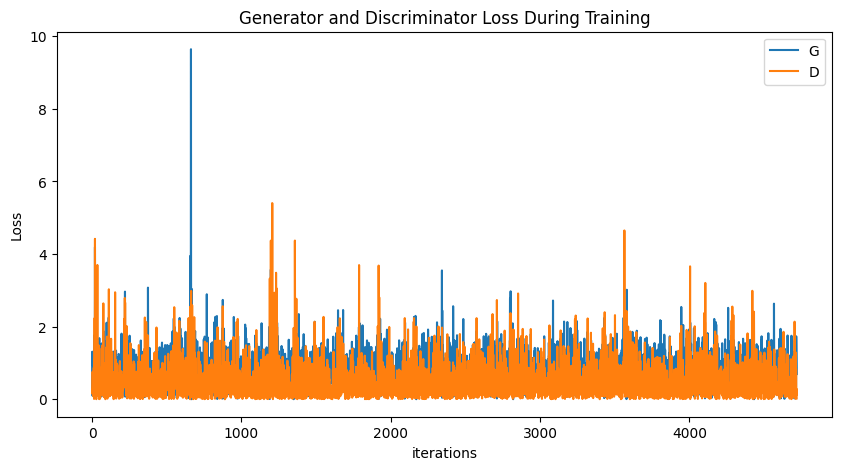

In [36]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [37]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

ani = animation.ArtistAnimation(fig, ims, repeat_delay=800, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
from PIL import Image
from torchvision import transforms

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 이미지 크기를 512x512로 조정합니다.
    transforms.ToTensor(),  # 이미지를 텐서로 변환합니다.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화합니다.
])

# Create an empty list to store resized images
resized_img_list = []

# Iterate through img_list and apply the transformation
for img_tensor in img_list:
    # Convert the tensor to a PIL Image
    img_pil = transforms.ToPILImage()(img_tensor)

    # Apply the transformation
    resized_img_tensor = transform(img_pil)

    # Add it to the new list
    resized_img_list.append(resized_img_tensor)

# Now resized_img_list contains images resized to 512x512


In [ ]:
# Importing required libraries for image visualization
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Function to denormalize and show image
def imshow(img):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Example: Showing the first image from the (hypothetical) resized_img_list
# Note: This is just a demonstration. In your actual code, you would replace 'first_resized_img' with the actual tensor from 'resized_img_list'.
# first_resized_img = resized_img_list[0]
# imshow(vutils.make_grid(first_resized_img, padding=2, normalize=True))


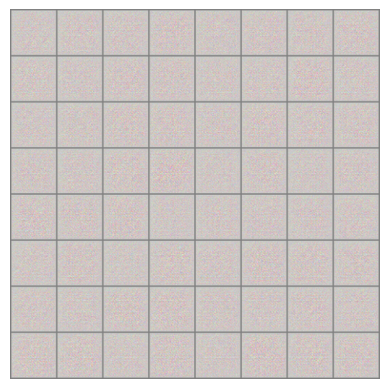

In [ ]:
imshow(vutils.make_grid(resized_img_list[0], padding=2, normalize=True))
